<a href="https://colab.research.google.com/github/Chirag-Shilwant/Classification-using-Siamese-Network-on-MNIST-Dataset/blob/main/Siamese_Network_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import keras as ks
import tensorflow as tf
import pickle
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import keras
import random
import tensorflow_addons as tfa

In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 5.9MB/s 


# **Loading the Dataset**

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
# Normalizing
X_train = X_train.astype('float32')
X_train /= 255
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.astype('float32')
X_test /= 255
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [ ]:
print("Shape of training data:")
print(X_train.shape)
print(Y_train.shape)

print("Shape of test data:")
print(X_test.shape)
print(Y_test.shape)

Shape of training data:
(60000, 784)
(60000,)
Shape of test data:
(10000, 784)
(10000,)


# **Making Pairs for One Shot Learning**

In [ ]:
class Pairs:
  def makePairs(self, x, y):
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = list()
    labels = list()

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        labels += list([1])
        pairs += [[x1, x2]]
    
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        labels += list([0])
        pairs += [[x1, x2]]
        
    return np.array(pairs), np.array(labels)

In [ ]:
p = Pairs()

In [ ]:
pairs_train, labels_train = p.makePairs(X_train, Y_train)
pairs_test, labels_test = p.makePairs(X_test, Y_test)
labels_train = labels_train.astype('float32')
labels_test = labels_test.astype('float32')

# **Siamese Network**

In [ ]:
def euclideanDistance(v):
    x, y = v
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_original, y_pred):
    sqaure_pred = K.square(y_pred)
    margin = 1
    margin_square = K.square(K.maximum(0, margin - y_pred))
    return K.mean(y_original * sqaure_pred + (1 - y_original) * margin_square)

def compute_accuracy(y_original, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_original)

def accuracy(y_original, y_pred):
    return K.mean(K.equal(y_original, K.cast(y_pred < 0.5, y_original.dtype)))

In [ ]:
input = Input(shape=(784,))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)


input1 = Input(shape=(784,))
input2 = Input(shape=(784,))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)

# **Contrastive loss**

In [ ]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_92 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_59 (Functional)           (None, 256)          91584       input_92[0][0]                   
                                                                 input_93[0][0]                   
__________________________________________________________________________________________________
lambda_86 (Lambda)              (None, 1)            0           model_59[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0933 - accuracy: 0.8839 - val_loss: 0.0379 - val_accuracy: 0.9595
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0277 - accuracy: 0.9707 - val_loss: 0.0292 - val_accuracy: 0.9643
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0179 - accuracy: 0.9808 - val_loss: 0.0250 - val_accuracy: 0.9693
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0132 - accuracy: 0.9855 - val_loss: 0.0242 - val_accuracy: 0.9708
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0105 - accuracy: 0.9891 - val_loss: 0.0247 - val_accuracy: 0.9692
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0085 - accuracy: 0.9912 - val_loss: 0.0236 - val_accuracy: 0.9710
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0072 - accuracy: 0.9928 - val_loss: 0.0247 - val_accuracy: 0.9696
Epoch 

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 97.28999999999999


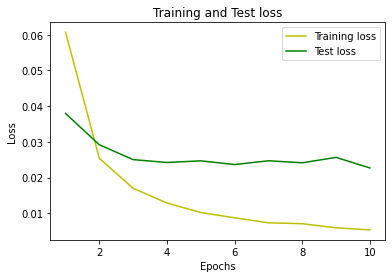

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Triplet Loss**

In [ ]:
model.compile(loss = tfa.losses.TripletSemiHardLoss(), optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_95 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_61 (Functional)           (None, 256)          91584       input_95[0][0]                   
                                                                 input_96[0][0]                   
__________________________________________________________________________________________________
lambda_89 (Lambda)              (None, 1)            0           model_61[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 48s 50ms/step - loss: 0.9227 - accuracy: 0.7951 - val_loss: 0.7593 - val_accuracy: 0.9112
Epoch 2/10
938/938 [==============================] - 46s 49ms/step - loss: 0.7313 - accuracy: 0.9213 - val_loss: 0.6899 - val_accuracy: 0.9357
Epoch 3/10
938/938 [==============================] - 46s 49ms/step - loss: 0.6471 - accuracy: 0.9440 - val_loss: 0.6710 - val_accuracy: 0.9409
Epoch 4/10
938/938 [==============================] - 46s 49ms/step - loss: 0.5861 - accuracy: 0.9525 - val_loss: 0.6153 - val_accuracy: 0.9477
Epoch 5/10
938/938 [==============================] - 46s 49ms/step - loss: 0.5277 - accuracy: 0.9607 - val_loss: 0.6208 - val_accuracy: 0.9454
Epoch 6/10
938/938 [==============================] - 46s 49ms/step - loss: 0.5000 - accuracy: 0.9649 - val_loss: 0.6372 - val_accuracy: 0.9476
Epoch 7/10
938/938 [==============================] - 46s 49ms/step - loss: 0.4554 - accuracy: 0.9689 - val_loss: 0.6254 - val_accuracy:

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 96.03


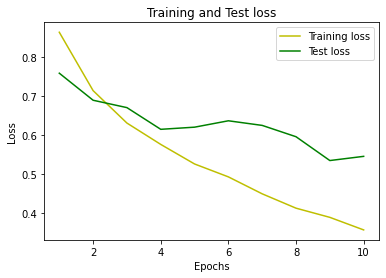

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Regularized Cross Entropy**

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_98 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_99 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_63 (Functional)           (None, 256)          91584       input_98[0][0]                   
                                                                 input_99[0][0]                   
__________________________________________________________________________________________________
lambda_92 (Lambda)              (None, 1)            0           model_63[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 5.9396e-08 - accuracy: 0.5536 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 5.9753e-08 - accuracy: 0.5495 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 5.9568e-08 - accuracy: 0.5524 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 6.0025e-08 - accuracy: 0.5482 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 5.9663e-08 - accuracy: 0.5512 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 5.9573e-08 - accuracy: 0.5505 - val_loss: 5.9605e-08 - val_accuracy: 0.5602
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 5.9407e-08 - accuracy: 0.5

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 55.97


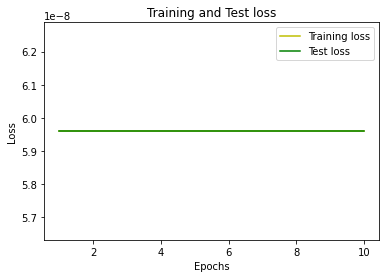

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Comparison of Regularized Cross Entropy, Triplet Loss and Contrastive loss functions**

*   Test Accuracy using **Contrastive loss : 97.289%**
*   Test Accuracy using **Triplet Loss : 96.030%**
*   Test Accuracy using **Regularized Cross Entropy : 55.97%**

Hence, **Contrastive loss is best** among all three loss functions.

# **Siamese Network with various Optimisers**

**RMSprop**

In [ ]:
model.compile(loss = contrastive_loss, optimizer="RMSprop", metrics=[accuracy])
model.summary()

Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_122 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_79 (Functional)           (None, 256)          91584       input_122[0][0]                  
                                                                 input_123[0][0]                  
__________________________________________________________________________________________________
lambda_116 (Lambda)             (None, 1)            0           model_79[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0888 - accuracy: 0.8892 - val_loss: 0.0401 - val_accuracy: 0.9552
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0280 - accuracy: 0.9702 - val_loss: 0.0275 - val_accuracy: 0.9674
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0181 - accuracy: 0.9801 - val_loss: 0.0242 - val_accuracy: 0.9697
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0130 - accuracy: 0.9857 - val_loss: 0.0227 - val_accuracy: 0.9725
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0102 - accuracy: 0.9888 - val_loss: 0.0243 - val_accuracy: 0.9696
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0090 - accuracy: 0.9904 - val_loss: 0.0228 - val_accuracy: 0.9723
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0074 - accuracy: 0.9924 - val_loss: 0.0230 - val_accuracy: 0.9717
Epoch 

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 96.18345000000001


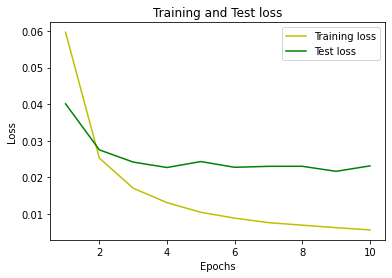

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Mini Batch Gradient Descent**

In [ ]:
model.compile(loss = contrastive_loss, optimizer="SGD", metrics=[accuracy])
model.summary()

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_119 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_120 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_77 (Functional)           (None, 256)          91584       input_119[0][0]                  
                                                                 input_120[0][0]                  
__________________________________________________________________________________________________
lambda_113 (Lambda)             (None, 1)            0           model_77[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 7ms/step - loss: 0.2147 - accuracy: 0.6786 - val_loss: 0.1529 - val_accuracy: 0.8081
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1472 - accuracy: 0.8129 - val_loss: 0.1327 - val_accuracy: 0.8345
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1298 - accuracy: 0.8383 - val_loss: 0.1222 - val_accuracy: 0.8502
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1207 - accuracy: 0.8514 - val_loss: 0.1151 - val_accuracy: 0.8589
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1140 - accuracy: 0.8613 - val_loss: 0.1099 - val_accuracy: 0.8660
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1080 - accuracy: 0.8696 - val_loss: 0.1056 - val_accuracy: 0.8718
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1041 - accuracy: 0.8751 - val_loss: 0.1019 - val_accuracy: 0.8765
Epoch 

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 88.615


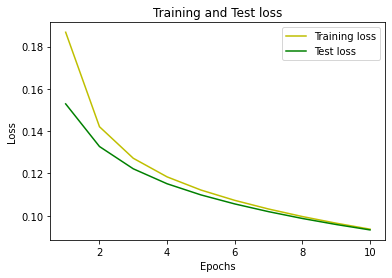

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Adam Optimizer**

In [ ]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_113 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_114 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_73 (Functional)           (None, 256)          91584       input_113[0][0]                  
                                                                 input_114[0][0]                  
__________________________________________________________________________________________________
lambda_107 (Lambda)             (None, 1)            0           model_73[0][0]            

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0933 - accuracy: 0.8839 - val_loss: 0.0379 - val_accuracy: 0.9595
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0277 - accuracy: 0.9707 - val_loss: 0.0292 - val_accuracy: 0.9643
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0179 - accuracy: 0.9808 - val_loss: 0.0250 - val_accuracy: 0.9693
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0132 - accuracy: 0.9855 - val_loss: 0.0242 - val_accuracy: 0.9708
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0105 - accuracy: 0.9891 - val_loss: 0.0247 - val_accuracy: 0.9692
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0085 - accuracy: 0.9912 - val_loss: 0.0236 - val_accuracy: 0.9710
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0072 - accuracy: 0.9928 - val_loss: 0.0247 - val_accuracy: 0.9696
Epoch 

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 97.28999999999999


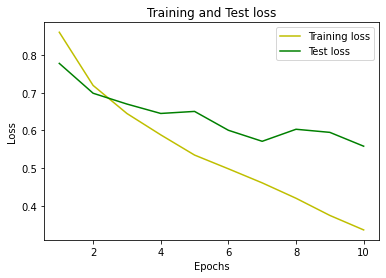

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Comparison of RMSProp, Mini Batch Gradient Descent and Adam Optimizer**

Accuracy of Siamese Network using different optimizers are:
*  Test Accuracy using **RMSProp optimizer: 96.189%**
*  Test Accuracy using **Mini Batch Gradient Descent optimizer: 88.615%**
*  Test Accuracy using **Adam optimizer: 97.289%**


As we can see that Adam and RMSProp optimizer gave around same accuracies with Adam giving slightly higher. The update rule for Adam is very similar to RMSProp, except we look at the cumulative history of gradients which speeds up the process in case of Adam.


The **best optimizer I think is Adam Optimizer** and the reasons are :

* Adam combines the best properties of RMSProp and AdaGrad to work well even with noisy or sparse datasets.
* Adam is well suited for problems that are large in terms of data and/or parameters.
* Adam is Computationally efficient and has Little memory requirements.


# **Hyper Parameter Optimization on Siamese Network with Adam optimizer**

In [ ]:
opt = ks.optimizers.Adam(learning_rate=0.0005, beta_1=0.888, beta_2=0.8888, epsilon=1e-8)

In [ ]:
model.compile(loss = contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_102"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_155 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_156 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_101 (Functional)          (None, 256)          91584       input_155[0][0]                  
                                                                 input_156[0][0]                  
__________________________________________________________________________________________________
lambda_149 (Lambda)             (None, 1)            0           model_101[0][0]          

In [ ]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1139 - accuracy: 0.8523 - val_loss: 0.0468 - val_accuracy: 0.9489
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0386 - accuracy: 0.9604 - val_loss: 0.0319 - val_accuracy: 0.9655
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0237 - accuracy: 0.9757 - val_loss: 0.0274 - val_accuracy: 0.9669
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0167 - accuracy: 0.9828 - val_loss: 0.0256 - val_accuracy: 0.9701
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0129 - accuracy: 0.9868 - val_loss: 0.0255 - val_accuracy: 0.9673
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0107 - accuracy: 0.9890 - val_loss: 0.0243 - val_accuracy: 0.9705
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0087 - accuracy: 0.9912 - val_loss: 0.0228 - val_accuracy: 0.9726
Epoch 

In [ ]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 97.59555


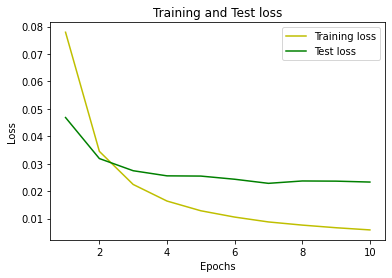

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Accuracies before and after Hyper Parameter Optimization**

For Siamese Network With Adam Optimizer,
* Before Hyper Parameter Optimization, the **Accuracy is 97.289%**
* After Hyper Parameter Optimization, the **Accuracy increased to 97.595%**

Changes made in hyperparameters are as follows,

**learning_rate=0.0005, beta_1=0.888, beta_2=0.8888, epsilon=1e-8**

# **Pros and Cons of Siamese Networks**

**Pros of Siamese Network**
1. Given a few images per class, Siamese Networks will recognise those images in the future with the help of One-shot learning.
2. Siamese focuses on learning embeddings (in the deeper layer) that group together similar classes and concepts. As a result, semantic similarity can be learned.



**Cons of Siamese Network**
1. Siamese Networks need more training time than normal networks because they use quadratic pairs to learn from, and they are slower than normal classification learning.
2. Since pairwise learning is used in training, the distance from each class will be output instead of the prediction probabilities.


